# Segmentation sémantique avec Unet
![](https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/muenster00.png)

L'objectif de ce projet est de concevoir un modèle de segmentation d’images semantique. La segmentation sémantique est un algorithme de Deep Learning qui associe une catégorie à chaque pixel d'une image. Elle permet de reconnaître un ensemble de pixels qui forment des catégories distinctes.

Les images sont issues du jeux de données de [cityscape](https://www.cityscapes-dataset.com). Le nombre de categorie est réduit de 37 à 8.
  - void
  - flat
  - construction
  - object
  - nature
  - sky
  - human
  - vehicle


Dans ce notebook nous allons explorer un modèle **Unet** qui sera entrainé  avec une perte de type **Catégorical Cross Entropy** et avec une perte de type **Dice**.

## Calcul de la perte

### Catégorical Cross Entropy
Il s'agit d'une fonction de perte utilisée généralement pour des problème de catégorisation et qui mesure la sililarité entre deux distributions de probabilité, généralement les étiquettes rréelles et les étiquetes prédites.


## Modèle U-Net
Le modèle U-net a été proposé pour la première fois par : Olaf Ronneberger, Philipp Fischer et Thomas Brox dans leur article intitulé "U-Net: Convolutional Networks for Biomedical Image Segmentation". Le modèle U-net est construit sur le modèle FCN-8 pour s'adapter à l'imagerie médicale. 

![](https://miro.medium.com/max/1400/1*f7YOaE4TWubwaFF7Z1fzNw.png)

C'est un modèle symétrique en forme de U séparé par un bottleneck. La première partie appelée contraction ou downsampling effectue l'extraction des caractéristiques contextuelles, la deuxième partie est le bottleneck qui force le modèle à apprendre d'une compression des données d'entrée et la dernière partie (qui est l'inverse exact de la première partie) appelée expansion ou upsampling effectue la localisation des caractéristiques.
Un des avantages de ce modèle c'est qu'il est plus rapide qu'un modèle FCN.







# Chargement des bibliothèques

In [2]:
import tensorflow as tf
from keras import optimizers
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import gc
import random
from keras.utils.vis_utils import plot_model

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Mount Google drive
from google.colab import drive
import os
import sys

drive.mount("/content/drive", force_remount=True)
app_folder = '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/'


Mounted at /content/drive


## Chargement des modules supplémentaires

In [5]:
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Models' .
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Losses' .
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Metrics' .
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Dataset' .


In [6]:
%reload_ext autoreload
from Models import build_model
from Losses import LOSS_FACTORY
from Metrics import METRIC_FACTORY
from Dataset import get_data
from Dataset import categories
from Dataset import load_data
from Dataset import set_color_to_mask
from Dataset import data_generator
from Dataset.data_generator import data_generator
from Metrics.iou_coef import IoU


# Definition des variables

In [7]:
EPOCHS = 100
patience = 30
model_name = 'unet'
optimizer_name = 'adam'
n_classes = 8
input_height = 128
input_width = 256
BATCH_SIZE = 64


# Chargement des données

In [8]:
# get Val data set frol google drive
get_data('gdrive',app_folder + '/data/', 'train')

In [9]:
# Load data into numpy array
imgs, masks = load_data('train', input_height,input_width, 3000)

In [10]:
print(f"{len(imgs)} images and {len(masks)} images mask")
print(f"Images properties: {np.array(imgs).shape}")
print(f"Masks properties: {np.array(masks).shape}")

2975 images and 2975 images mask
Images properties: (2975, 128, 256, 3)
Masks properties: (2975, 128, 256, 8)


## Exemple d'image

Image #81


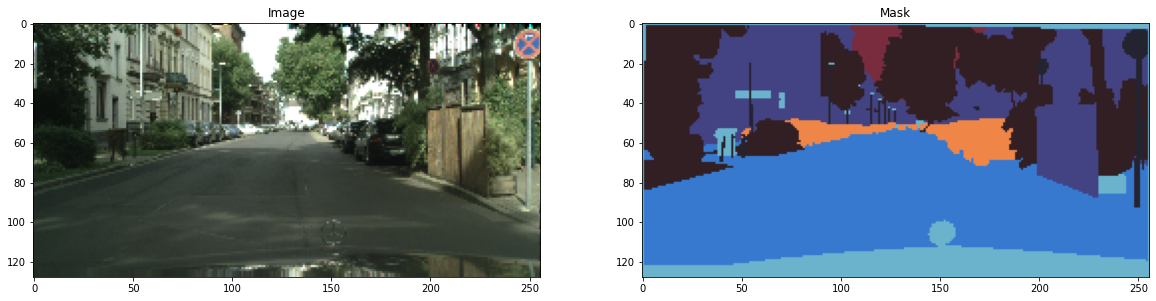

0

In [11]:
index = random.randint(0, len(imgs))
print(f"Image #{index}")
fig, (arr1, arr2) = plt.subplots(1,2, figsize=(20,40))

arr1.imshow(imgs[index])
arr1.set_title('Image')

# Convert mask
mask = np.squeeze(masks)
mask = np.argmax(mask, axis=3)
arr2.imshow(set_color_to_mask(mask[index]))
arr2.set_title('Mask')
plt.show()
gc.collect()

In [12]:
sns.color_palette("icefire", len(categories))

[(0.42110294, 0.69916972, 0.80506683),
 (0.2157176, 0.47827123, 0.81487615),
 (0.2659204, 0.25949691, 0.511417),
 (0.14254381, 0.14016944, 0.18944326),
 (0.19884415, 0.12394381, 0.1385669),
 (0.47151732, 0.17401641, 0.24610337),
 (0.78979746, 0.24694858, 0.22678822),
 (0.93850535, 0.52748892, 0.28242464)]

In [13]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(np.squeeze(imgs), np.squeeze(masks), test_size=0.25, random_state=63)
gc.collect()

72

# Preparation du modèle Unet

## Construction du modèle

In [14]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    patience=patience,
    verbose=1
  ),  
  tf.keras.callbacks.ReduceLROnPlateau('loss',
    factor=0.01,
    patience=int(patience / 2),
    verbose=1
  )
]
loss_func  = 'categorical_crossentropy'


model = build_model('unet',n_classes,input_height=input_height,input_width=input_width)
# compile
model.compile(loss=loss_func,optimizer='adam', metrics=['accuracy',METRIC_FACTORY['iou_coef'], METRIC_FACTORY['dice_coef']])

In [15]:
#model.summary()
#plot_model(model, to_file='model_unet.png', show_shapes=True, show_layer_names=True)

# Entrainement du modèle

In [16]:
%%time
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_test.shape[0] // BATCH_SIZE

history = model.fit(
    X_train,
    y_train,
    steps_per_epoch=steps_per_epoch,     
    validation_data=(X_test,y_test), 
    epochs=EPOCHS,
    verbose=2,
    callbacks=[callbacks]
)


Epoch 1/100
34/34 - 29s - loss: 1.6407 - accuracy: 0.2954 - iou_coef: 0.1666 - dice_coef: 0.2835 - val_loss: 1.2592 - val_accuracy: 0.4408 - val_iou_coef: 0.2354 - val_dice_coef: 0.3807
Epoch 2/100
34/34 - 6s - loss: 1.1006 - accuracy: 0.5859 - iou_coef: 0.2673 - dice_coef: 0.4206 - val_loss: 0.9956 - val_accuracy: 0.6591 - val_iou_coef: 0.2805 - val_dice_coef: 0.4372
Epoch 3/100
34/34 - 6s - loss: 0.9385 - accuracy: 0.6513 - iou_coef: 0.3078 - dice_coef: 0.4695 - val_loss: 0.8953 - val_accuracy: 0.6692 - val_iou_coef: 0.3317 - val_dice_coef: 0.4969
Epoch 4/100
34/34 - 6s - loss: 0.8348 - accuracy: 0.7039 - iou_coef: 0.3340 - dice_coef: 0.4996 - val_loss: 0.7943 - val_accuracy: 0.6990 - val_iou_coef: 0.3556 - val_dice_coef: 0.5238
Epoch 5/100
34/34 - 6s - loss: 0.7401 - accuracy: 0.7544 - iou_coef: 0.3565 - dice_coef: 0.5245 - val_loss: 0.6740 - val_accuracy: 0.7816 - val_iou_coef: 0.3687 - val_dice_coef: 0.5376
Epoch 6/100
34/34 - 6s - loss: 0.6473 - accuracy: 0.7968 - iou_coef: 0.384

## Evaluation du modèle

In [17]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss : {score[0]}")
print(f"Acuracy : {score[1]}")

24/24 [==============================] - 1s 35ms/step - loss: 0.6215 - accuracy: 0.8792 - iou_coef: 0.5932 - dice_coef: 0.7421
Loss : 0.6214627027511597
Acuracy : 0.8791527152061462


## Exemples de prédictions

In [18]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)

In [19]:
len(X_test)

744

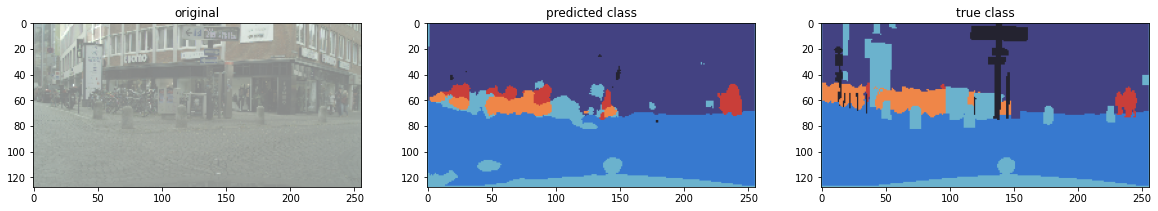

void          : 0.326
flat          : 0.481
construction  : 0.446
object        : 0.002
nature        :  nan
sky           :  nan
human         : 0.209
vehicle       : 0.282

Mean IoU:  nan


/content/Metrics/iou_coef.py:23: RuntimeWarning: invalid value encountered in long_scalars
  IoU = intersection / combined_area


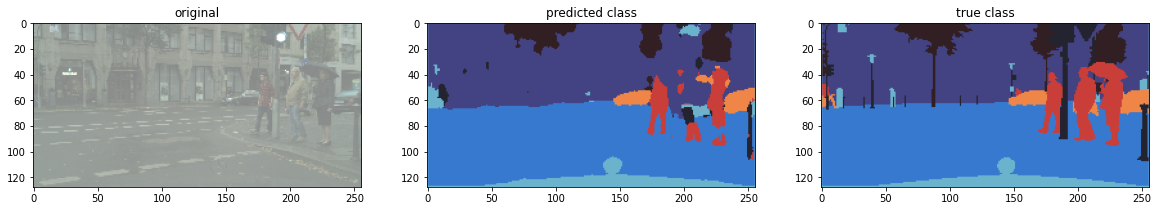

void          : 0.418
flat          : 0.487
construction  : 0.445
object        : 0.106
nature        : 0.420
sky           :  nan
human         : 0.325
vehicle       : 0.388

Mean IoU:  nan


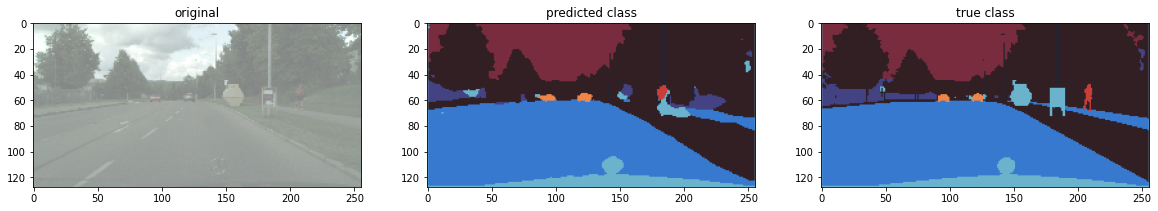

void          : 0.430
flat          : 0.491
construction  : 0.215
object        : 0.298
nature        : 0.470
sky           : 0.486
human         : 0.000
vehicle       : 0.410

Mean IoU: 0.350


37

In [20]:
import random

random_images = random.sample(range(len(X_test)), 3)
for i in random_images:
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(20,40))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(set_color_to_mask(seg))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(set_color_to_mask(segtest))
    ax.set_title("true class")
    plt.show()

    IoU(y_testi[i],y_predi[i],categories)
gc.collect()

# Conclusion

Ce modèle montre de très bonnes performances en temps de traitement. Au contraire du modèle FCN la catégorie "Human" est mieux détectée.